1. Encoding the faces using OpenCV and deep learning

In [1]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

dataset = "./dataset"
encodings_file = "encodings.pickle"
# two face detection methods include either hog or cnn. 
# Those two flags are the only ones that will work.
detection_method = "cnn"

# grab the paths to the input images in our dataset
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images(dataset))

# initialize the list of known encodings and known names
knownEncodings = []
knownNames = []

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# extract the person name from the image path
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]
	
    # load the input image and convert it from BGR (OpenCV ordering)
	# to dlib ordering (RGB)
	image = cv2.imread(imagePath)
	rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	
    # detect the (x, y)-coordinates of the bounding boxes
	# corresponding to each face in the input image
	boxes = face_recognition.face_locations(rgb,
		model=detection_method)
	
    # compute the facial embedding for the face
	encodings = face_recognition.face_encodings(rgb, boxes)
	
    # loop over the encodings
	for encoding in encodings:
		# add each encoding + name to our set of known names and
		# encodings
		knownEncodings.append(encoding)
		knownNames.append(name)
	
# dump the facial encodings + names to disk
print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open(encodings_file, "wb")
f.write(pickle.dumps(data))
f.close()




[INFO] quantifying faces...
[INFO] processing image 1/11
[INFO] processing image 2/11
[INFO] processing image 3/11
[INFO] processing image 4/11
[INFO] processing image 5/11
[INFO] processing image 6/11
[INFO] processing image 7/11
[INFO] processing image 8/11
[INFO] processing image 9/11
[INFO] processing image 10/11
[INFO] processing image 11/11
[INFO] serializing encodings...


2. Recognizing faces in images

[INFO] loading encodings...
[INFO] recognizing faces...


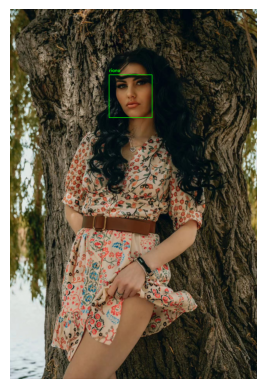

In [6]:
import matplotlib.pyplot as plt
import face_recognition
import pickle
import cv2

encodings_file = "encodings.pickle"
image_path = "./images/IMG_8504.jpeg"
detection_method = "hog"

# load the known faces and embeddings
print("[INFO] loading encodings...")
data = pickle.loads(open(encodings_file, "rb").read())

# load the input image and convert it from BGR to RGB
image = cv2.imread(image_path)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# detect the (x, y)-coordinates of the bounding boxes corresponding
# to each face in the input image, then compute the facial embeddings
# for each face
print("[INFO] recognizing faces...")
boxes = face_recognition.face_locations(rgb,
	model=detection_method)
encodings = face_recognition.face_encodings(rgb, boxes)

# initialize the list of names for each face detected
names = []

# loop over the facial embeddings
for encoding in encodings:
	# attempt to match each face in the input image to our known
	# encodings
	matches = face_recognition.compare_faces(data["encodings"],
		encoding)
	name = "Unknown"
	
    # check to see if we have found a match
	if True in matches:
		# find the indexes of all matched faces then initialize a
		# dictionary to count the total number of times each face
		# was matched
		matchedIdxs = [i for (i, b) in enumerate(matches) if b]
		counts = {}
		
        # loop over the matched indexes and maintain a count for
		# each recognized face face
		for i in matchedIdxs:
			name = data["names"][i]
			counts[name] = counts.get(name, 0) + 1

		# determine the recognized face with the largest number of
		# votes (note: in the event of an unlikely tie Python will
		# select first entry in the dictionary)
		name = max(counts, key=counts.get)
		
    # update the list of names
	names.append(name)
	
# loop over the recognized faces
for ((top, right, bottom, left), name) in zip(boxes, names):
	# draw the predicted face name on the image
	cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
	y = top - 15 if top - 15 > 15 else top + 15
	cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		0.75, (0, 255, 0), 2)
	
# show the output image
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


3. Recognizing faces in video

In [ ]:
from imutils.video import FileVideoStream
import matplotlib.pyplot as plt
import face_recognition
import imutils
import pickle
import time
import cv2

encodings_file = "encodings.pickle"
video_path = "./videos/riana.mp4"
output_path = "./output/face_recognition_output.avi"
detection_method = "hog"

# load the known faces and embeddings
print("[INFO] loading encodings...")
data = pickle.loads(open(encodings_file, "rb").read())

# initialize the video stream and pointer to output video file, then
# allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = FileVideoStream(path=video_path).start()
writer = None
time.sleep(2.0)

# loop over frames from the video file stream
while vs.more():
	# grab the frame from the threaded video stream
	frame = vs.read()
	
	# convert the input frame from BGR to RGB then resize it to have
	# a width of 750px (to speedup processing)
	rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	rgb = imutils.resize(frame, width=750)
	r = frame.shape[1] / float(rgb.shape[1])

	# detect the (x, y)-coordinates of the bounding boxes
	# corresponding to each face in the input frame, then compute
	# the facial embeddings for each face
	boxes = face_recognition.face_locations(rgb,
		model=detection_method)
	encodings = face_recognition.face_encodings(rgb, boxes)
	names = []
	
    # loop over the facial embeddings
	for encoding in encodings:
		# attempt to match each face in the input image to our known
		# encodings
		matches = face_recognition.compare_faces(data["encodings"],
			encoding)
		name = "Unknown"

		# check to see if we have found a match
		if True in matches:
			# find the indexes of all matched faces then initialize a
			# dictionary to count the total number of times each face
			# was matched
			matchedIdxs = [i for (i, b) in enumerate(matches) if b]
			counts = {}

			# loop over the matched indexes and maintain a count for
			# each recognized face face
			for i in matchedIdxs:
				name = data["names"][i]
				counts[name] = counts.get(name, 0) + 1

			# determine the recognized face with the largest number
			# of votes (note: in the event of an unlikely tie Python
			# will select first entry in the dictionary)
			name = max(counts, key=counts.get)
		names.append(name)
		
    # loop over the recognized faces
	for ((top, right, bottom, left), name) in zip(boxes, names):
		# rescale the face coordinates
		top = int(top * r)
		right = int(right * r)
		bottom = int(bottom * r)
		left = int(left * r)

		# draw the predicted face name on the image
		cv2.rectangle(frame, (left, top), (right, bottom),
			(0, 255, 0), 2)
		y = top - 15 if top - 15 > 15 else top + 15
		cv2.putText(frame, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
			0.75, (0, 255, 0), 2)
		
    # if the video writer is None *AND* we are supposed to write
	# the output video to disk initialize the writer
	if writer is None and output_path is not None:
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(output_path, fourcc, 20,
			(frame.shape[1], frame.shape[0]), True)

	# if the writer is not None, write the frame with recognized
	# faces to disk
	if writer is not None:
		writer.write(frame)

	plt.axis("off")
	plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
	plt.show()
    	
vs.stop()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()
		
